In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from mpl_toolkits import mplot3d
from pauli import *
from qm_tools import sort_eigensystem, plot_spectrum
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN
import networkx as nx
from scipy.spatial import distance
from plot_tools import multiplot_2d

plt.style.use("../plot_style.mplstyle")

# Define TRIM points
trim_def = {
    "G": np.array((0, 0)),
    "X": np.array((np.pi, 0)),
    "-X": np.array((-np.pi, 0)),
    "Y": np.array((0, np.pi)),
    "-Y": np.array((0, -np.pi)),
    "M": np.array((np.pi, np.pi)),
    "-M": np.array((-np.pi, -np.pi)),
}


def generate_k_path(path, num_points=100):
    """
    Generate a path in k-space connecting the given TRIM points.

    Parameters:
    - path: List of TRIM point labels to connect.
    - num_points: Number of points to generate between each pair of TRIM points.

    Returns:
    - kx_array: Array of kx points along the path.
    - ky_array: Array of ky points along the path.
    - t_array: Array of points representing the relative positions along the path.
    """
    kx_array = []
    ky_array = []
    t_array = []

    for i in range(len(path) - 1):
        start_point = trim_def[path[i]]
        end_point = trim_def[path[i + 1]]
        segment = np.linspace(start_point, end_point, num_points, endpoint=False)
        t = np.linspace(i, i + 1, num_points, endpoint=False)

        kx_array.extend(segment[:, 0])
        ky_array.extend(segment[:, 1])
        t_array.extend(t)

    # Append the last point
    kx_array.append(trim_def[path[-1]][0])
    ky_array.append(trim_def[path[-1]][1])
    t_array.append(len(path) - 1)

    return np.array(kx_array), np.array(ky_array), np.array(t_array)


def H_n(kx, ky, mu, az, eta, hx, hy, hz):
    H = np.zeros((2, 2), dtype=complex)

    H += np.kron(s0, 2 * (2 - np.cos(kx) - np.cos(ky)) - mu)

    H += np.kron(sy, +az * np.sin(kx))
    H += np.kron(sx, -az * np.sin(ky))

    H += np.kron(sx, hx)
    H += np.kron(sy, hy)
    H += np.kron(sz, hz)

    H += np.kron(sz, 2 * eta * (np.cos(kx) - np.cos(ky)))

    return H

In [2]:
mu, az, eta, hx, hy, hz = (0.5, 0.04, 0.25, 0, 0, 0)

In [3]:
path = ["-X", "G", "X", "M", "Y", "G", "-Y"]
kx_array, ky_array, t_array = generate_k_path(path, 100)

ws, vs = [], []

for kx, ky in zip(kx_array, ky_array):
    H = H_n(kx, ky, mu, az, eta, hx, hy, hz)
    eigvals, eigvecs = la.eigh(H)
    ws.append(eigvals)
    vs.append(eigvecs)

ws = np.array(ws)
vs = np.array(vs)
ws, vs = sort_eigensystem(ws, vs)
szs = np.einsum("nmi, ij, nmj -> nm", vs, sz, vs.conj()).real

In [4]:
cmap = plt.get_cmap("RdBu_r")

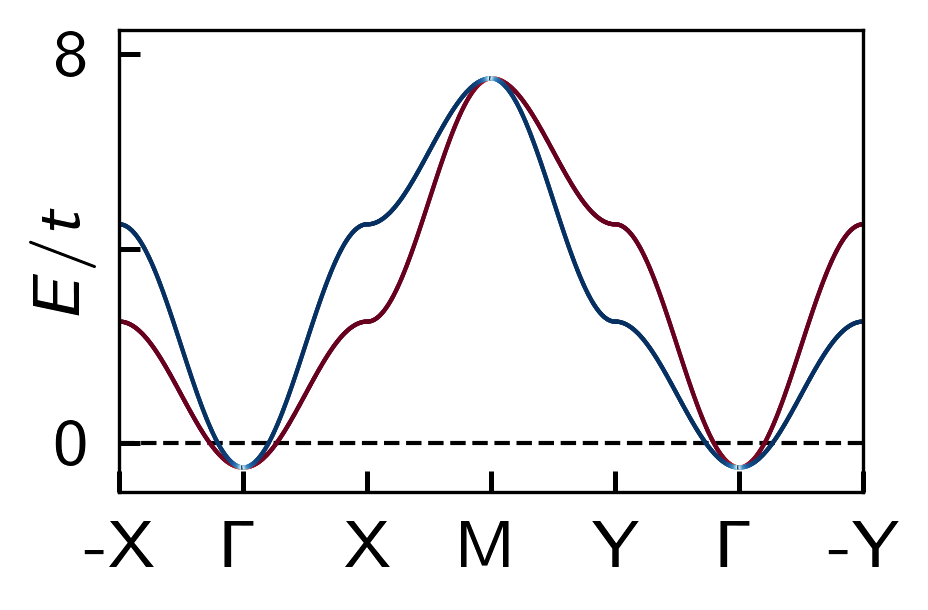

In [5]:
# Plotting the band structure with colormap
fig, ax = plt.subplots(figsize=(1.6, 1))

# Normalize the sz values for colormap
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ax.hlines([0], 0, 6, linestyles="--", colors="k")

for i in range(ws.shape[1]):
    colors = cmap(norm(szs[:, i]))
    for j in range(len(ws) - 1):
        ax.plot(t_array[j : j + 2], ws[j : j + 2, i], "-", color=colors[j])

# # Add a colorbar to the plot
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Sz value')

ax.set_xlim(0, 6)
ax.set_xticks(np.arange(len(path)))
ax.set_xticklabels(["-X", r"$\Gamma$", "X", "M", "Y", r"$\Gamma$", "-Y"])

ax.set_ylim(-1, 8.5)
ax.set_yticks([0, 4, 8], ["0", "", "8"])
ax.set_ylabel(r"$E / t$", labelpad=-5)

fig.savefig("Fig1a.svg")

In [6]:
tolerance = 5e-3

# Create a meshgrid of kx, ky points
kx_vals = np.linspace(-np.pi, np.pi, 801)
ky_vals = np.linspace(-np.pi, np.pi, 801)
kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals)

# Lists to store the kx, ky points where ws is approximately zero and their sz values
zero_kx = []
zero_ky = []
sz_values = []

# Diagonalize the Hamiltonian at each point and check for zero eigenvalues
for i, kx in enumerate(kx_vals):
    for j, ky in enumerate(ky_vals):
        H = H_n(kx, ky, mu, az, eta, hx, hy, hz)

        eigvals, eigvecs = la.eigh(H)
        for n in range(2):
            if np.abs(eigvals[n]) < tolerance:
                zero_kx.append(kx)
                zero_ky.append(ky)
                sz_val = np.einsum(
                    "i, ij, j", eigvecs[:, n], sz, eigvecs[:, n].conj()
                ).real
                sz_values.append(sz_val)

# Convert lists to arrays for plotting
zero_kx = np.array(zero_kx)
zero_ky = np.array(zero_ky)
sz_values = np.array(sz_values)

(-1.0471975511965976, 1.0471975511965976)

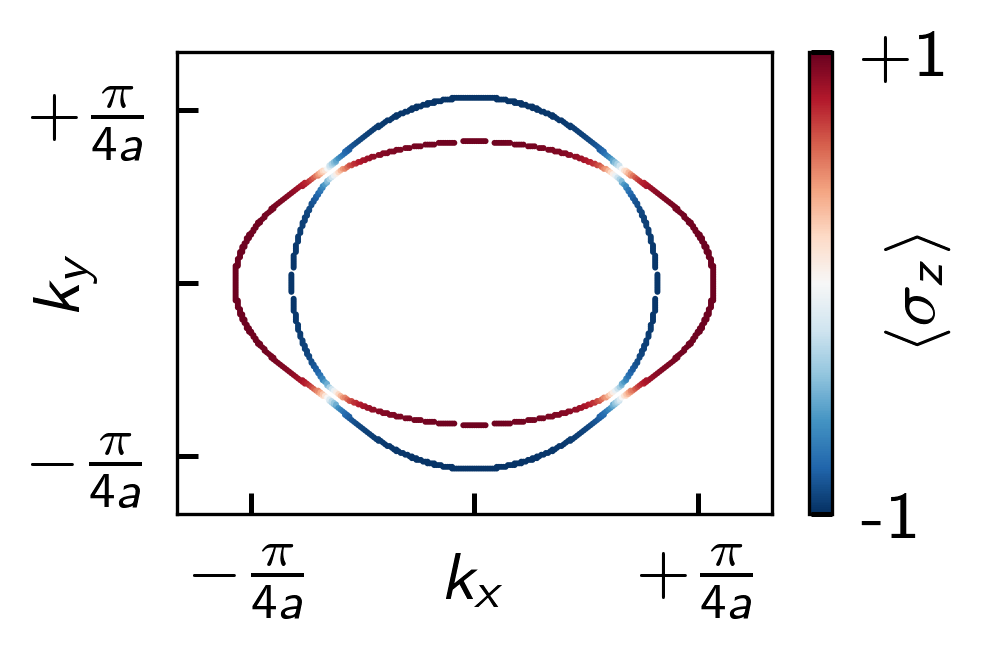

In [7]:
# Plot the points where ws is approximately zero with color based on sz values
fig, ax = plt.subplots(figsize=(1.6, 1))
scatter = ax.scatter(
    zero_kx,
    zero_ky,
    c=sz_values,
    cmap=cmap,
    marker="o",
    linewidth=0,
    s=0.5,
    vmin=-1,
    vmax=1,
    alpha=1,
)
ax.set_xticks(
    [-np.pi / 4, 0, np.pi / 4], labels=[r"$-\frac{\pi}{4a}$", "", r"$+\frac{\pi}{4a}$"]
)
ax.set_yticks(
    [-np.pi / 4, 0, np.pi / 4], labels=[r"$-\frac{\pi}{4a}$", "", r"$+\frac{\pi}{4a}$"]
)
ax.set_xlabel(r"$k_x$", labelpad=-8)
ax.set_ylabel(r"$k_y$", labelpad=-8)

cbar = fig.colorbar(scatter)
cbar.set_label(r"$\langle \sigma_z \rangle$", labelpad=-8)
cbar.set_ticks([-1, +1], labels=["-1", "+1"])

ax.set_xlim(-np.pi / 3, np.pi / 3)
ax.set_ylim(-np.pi / 3, np.pi / 3)

# fig.savefig("Fig1b.svg")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import scipy.linalg as la


def group_points_into_lines_dbscan(kx, ky, sz, eps, min_samples):
    points = np.column_stack((kx, ky))
    clustering = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=4).fit(points)
    labels = clustering.labels_

    lines = []
    for label in set(labels):
        if label == -1:
            continue
        mask = labels == label
        line_points = np.column_stack((kx[mask], ky[mask], sz[mask]))

        # Sort the points to form a continuous line
        line_points = sort_points_to_form_line(line_points)
        lines.append(line_points)

    return lines


def solve_tsp_with_networkx(dist_matrix):
    # Create a graph from the distance matrix
    G = nx.Graph()
    num_nodes = len(dist_matrix)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            G.add_edge(i, j, weight=dist_matrix[i, j])

    # Solve the TSP problem using the networkx approximation algorithm
    tsp_path = nx.approximation.traveling_salesman_problem(G, cycle=True)
    return tsp_path


def sort_points_to_form_line(points):
    # Compute the distance matrix
    dist_matrix = distance.cdist(points[:, :2], points[:, :2], "euclidean")

    # Solve the TSP
    tsp_path = solve_tsp_with_networkx(dist_matrix)

    # Return the points in the order of the TSP route
    return points[tsp_path]


def prepare_multiplot_data(lines):
    xs = []
    ys = []
    cs = []

    global min_sz, max_sz
    min_sz, max_sz = float("inf"), float("-inf")

    for line in lines:
        min_sz = min(min_sz, np.min(line[:, 2]))
        max_sz = max(max_sz, np.max(line[:, 2]))

    for line in lines:
        xs.append(line[:, 0])
        ys.append(line[:, 1])
        cs.append([cmap((point[2] - min_sz) / (max_sz - min_sz)) for point in line])

    return xs, ys, cs


def moving_average(x, y, sz, window_size):
    """
    Smooth the path using a moving average filter with periodic boundary conditions.

    Parameters:
    - x  : array-like, x-coordinates of the points
    - y  : array-like, y-coordinates of the points
    - sz : array-like, size or attribute of the points
    - window_size : size of the smoothing window

    Returns:
    - smoothed_x : array of x-coordinates of the smoothed path
    - smoothed_y : array of y-coordinates of the smoothed path
    - smoothed_sz : array of smoothed sizes or attributes
    """
    n = len(x)
    extended_x = np.concatenate([x, x[: window_size - 1]])
    extended_y = np.concatenate([y, y[: window_size - 1]])
    extended_sz = np.concatenate([sz, sz[: window_size - 1]])

    smoothed_x = np.convolve(
        extended_x, np.ones(window_size) / window_size, mode="valid"
    )
    smoothed_y = np.convolve(
        extended_y, np.ones(window_size) / window_size, mode="valid"
    )
    smoothed_sz = np.convolve(
        extended_sz, np.ones(window_size) / window_size, mode="valid"
    )

    # Extract the relevant part of the smoothed data
    smoothed_x = smoothed_x[:n]
    smoothed_y = smoothed_y[:n]
    smoothed_sz = smoothed_sz[:n]

    return smoothed_x, smoothed_y, smoothed_sz


def smooth_lines(lines, window_size):
    smoothed_lines = []
    for line in lines:
        x, y, sz = line[:, 0], line[:, 1], line[:, 2]
        smoothed_x, smoothed_y, smoothed_sz = moving_average(x, y, sz, window_size)
        smoothed_lines.append(np.column_stack((smoothed_x, smoothed_y, smoothed_sz)))
    return smoothed_lines

In [9]:
# Group points into lines using DBSCAN
lines = group_points_into_lines_dbscan(
    zero_kx, zero_ky, sz_values, eps=0.039, min_samples=2
)
len(lines)

2

In [10]:
slines = smooth_lines(lines, window_size=12)
xs, ys, cs = prepare_multiplot_data(slines)

In [11]:
xs[0][-1] - xs[0][0]

-0.0019634954084936096

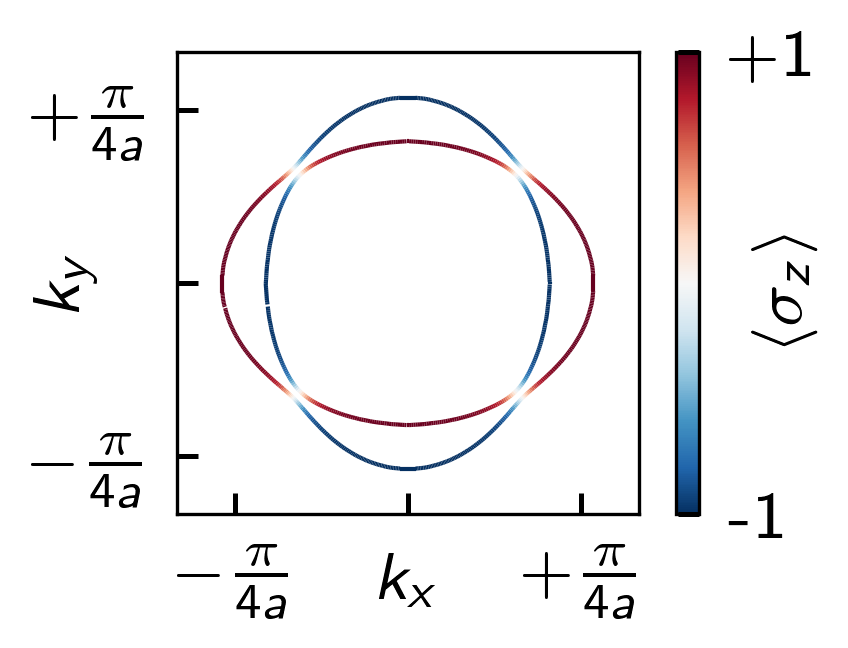

In [12]:
# Plot the points where ws is approximately zero with color based on sz values
fig, ax = plt.subplots(figsize=(1.6, 1))

multiplot_2d(xs, ys, cs, ax=ax)

ax.set_xticks(
    [-np.pi / 4, 0, np.pi / 4], labels=[r"$-\frac{\pi}{4a}$", "", r"$+\frac{\pi}{4a}$"]
)
ax.set_yticks(
    [-np.pi / 4, 0, np.pi / 4], labels=[r"$-\frac{\pi}{4a}$", "", r"$+\frac{\pi}{4a}$"]
)
ax.set_xlabel(r"$k_x$", labelpad=-8)
ax.set_ylabel(r"$k_y$", labelpad=-8)

cbar = fig.colorbar(scatter)
cbar.set_label(r"$\langle \sigma_z \rangle$", labelpad=-8)
cbar.set_ticks([-1, +1], labels=["-1", "+1"])

ax.set_xlim(-np.pi / 3, np.pi / 3)
ax.set_ylim(-np.pi / 3, np.pi / 3)

ax.set_aspect("equal")


# Create and add colorbar
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r"$\langle \sigma_z \rangle$", labelpad=-8)
cbar.set_ticks([-1, 1], labels=["-1", "+1"])

fig.savefig("Fig1b.svg")